In [1]:
####%%%%%!pip install autograd
########!pip install tensorflow

In [2]:
import tensorflow as tf
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
nx = 11
Tfinal=1
dx = Tfinal / (nx-1)

In [4]:
# psy' = -psy*A(x)+B(x)
def A(x):
    '''Left part of initial equation    '''
    return x + (1. + 3.*x**2) / (1. + x + x**3)
def B(x):
    '''Right part of initial equation'''
    return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))
def f(x, psy):
    '''d(psy)/dx = f(x, psy)This is f() function on the right'''
    return B(x) - psy * A(x)
def psy_analytic(x):
    ''' Analytical solution of current problem'''
    return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2
IC =1.

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] 0.1


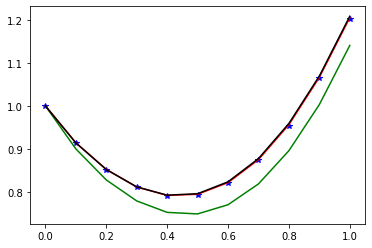

In [5]:
x_space = np.linspace(0, Tfinal, nx)    
y_space = psy_analytic(x_space)
print(x_space,dx)

psy_fd1 = np.zeros_like(y_space)
psy_fd1[0] = IC # IC
psy_fd2 = np.zeros_like(y_space)
psy_fd2[0] = IC # IC
psy_fd3 = np.zeros_like(y_space)
psy_fd3[0] = IC 
psy_fdd = np.zeros_like(y_space)

n=1
for i in range(1, len(x_space)):
    psy_fd1[i] = psy_fd1[i-1]  + dx*f(x_space[i-1],psy_fd1[i-1])

for i in range(1, len(x_space)):
    psy_fd2[i] = psy_fd2[i-1] + dx*f(x_space[i-1]+dx/2, psy_fd2[i-1]+dx*f(x_space[i-1],psy_fd2[i-1])/2)
    
for i in range(1, len(x_space)):
    psy_fdd[i] = psy_fd3[i-1]  + dx*f(x_space[i-1],psy_fd3[i-1])
    psy_fd3[i] = psy_fd3[i-1] + dx*(f(x_space[i-1],psy_fd3[i-1])+f(x_space[i],psy_fdd[i]))/2

psy_fd = psy_fd1
plt.figure()
plt.plot(x_space, y_space, 'b*')
plt.plot(x_space, psy_fd1, 'g')
plt.plot(x_space, psy_fd2, 'r')
plt.plot(x_space, psy_fd3, 'k')
plt.show()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

def loss_function(W, x, yhat):
    loss_sum = 0
    for i in range(0,len(x)):
        net_out = neural_network(W, x[i])[0][0]
        psy_t = yhat[i] +  x[i]**(n+1)*net_out

        d_net_out = d_neural_network_dx(W, x[i])[0][0]
        d_psy_t = f(x[i],yhat[i])+ (n+1)*(x[i]**n)*net_out + x[i]**(n+1)* d_net_out

        func = f(x[i], psy_t)
        err_sqr = (d_psy_t - func)**2
        loss_sum += err_sqr
    return loss_sum


In [7]:
# !pip install tqdm

In [8]:
import time

lmb = 0.001 # init : 0.001
samples = 100 # best result 개수

base_error = y_space - psy_fd
data = {'best_res_time' : [], 'break_average' : [], 'error_total' : [], 'bad_res' : 0}

while len(data['best_res_time']) != samples:
    time_start = time.perf_counter()
    W = [npr.randn(1, 10), npr.randn(10, 1)]
    
    if (data['bad_res'] + len(data['best_res_time']))//3 == samples // 3:
        print('좋은 데이터 개수 {} / {} \n버려진 데이터 : {} 개 \n --------------'.format(len(data['best_res_time']), samples, data['bad_res']))

    for i in range(5000):
        loss_grad = grad(loss_function)(W, x_space,psy_fd)
        
        W[0] = W[0] - lmb * loss_grad[0]
        W[1] = W[1] - lmb * loss_grad[1]

        cnt = 0
        for xi in x_space:
            if neural_network(W, xi)[0] < 0:    # 1차 거르는 단계, 첫번째는 초반부에 음수값으로 자리 잡기 시작하면 좋은 데이터가 잘 안나옴.
                continue
            else:
                cnt += 1

        y_error = y_space - (psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space])
        if cnt == len(x_space) and i > 1:
            e_cnt = 0
            for b_e, y_e in zip(base_error, y_error):
                if abs(b_e) < abs(y_e):
                    pass
                else:
                    e_cnt += 1
                        
            if e_cnt == len(y_error) and np.linalg.norm(y_error) < np.linalg.norm(base_error):   # 결과 값의 모든 에러가 베이스 에러보다 낮을 때 좋은 결과 데이터에 저장.
                data['best_res_time'].append(time.perf_counter() - time_start)
                data['break_average'].append(i)
                data['error_total'].append(np.linalg.norm(y_error))
                data['bad_res'] -= 1
                break

    data['bad_res'] += 1


좋은 데이터 개수 70 / 100 
버려진 데이터 : 29 개 
 --------------
좋은 데이터 개수 71 / 100 
버려진 데이터 : 29 개 
 --------------
좋은 데이터 개수 72 / 100 
버려진 데이터 : 29 개 
 --------------


In [9]:
print ("첫번째 코드 \n ------------- \n 총 데이터 개수 : {4} \n 결과가 좋은 데이터 개수 : {0} 개 \n 결과가 나쁜 데이터 개수 : {3} 개 \n -------------- \n 결과가 좋은 데이터 \n 평균 초 : {1:.1f} 초 \n 데이터 한개당 반복 횟수 : {2:} 번 \n 평균 에러 : {5:.5f} \n -------- \n 원본 에러 : {6:.5f} ".format(len(data['best_res_time']), sum(data['best_res_time']) / samples, sum(data['break_average']) / samples, data['bad_res'], data['bad_res'] + samples, sum(data['error_total']) / samples, np.linalg.norm(base_error)))

첫번째 코드 
 ------------- 
 총 데이터 개수 : 143 
 결과가 좋은 데이터 개수 : 100 개 
 결과가 나쁜 데이터 개수 : 43 개 
 -------------- 
 결과가 좋은 데이터 
 평균 초 : 6.0 초 
 데이터 한개당 반복 횟수 : 575.17 번 
 평균 에러 : 0.10039 
 -------- 
 원본 에러 : 0.14649 


Text(0, 0.5, 'Error')

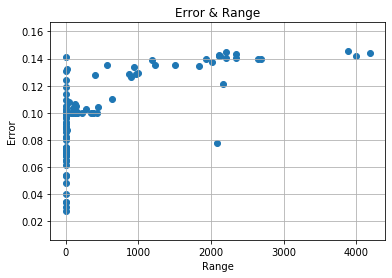

In [10]:
plt.scatter(data['break_average'], data['error_total'])
plt.title('Error & Range')   # 반복 횟수에 따른 에러 분포도
plt.grid(b = True)
plt.xlabel('Range')  # 반복 횟수
plt.ylabel('Error')  # 에러

In [11]:
data['error_total']

[0.03458837117937924,
 0.0743294270541224,
 0.09969220557865044,
 0.13862765038014485,
 0.10283493695180833,
 0.12417004219870292,
 0.1430883004358577,
 0.07325708405065204,
 0.10129903838142722,
 0.09954783904059931,
 0.10960396223603362,
 0.128790709218669,
 0.10491527816279163,
 0.08774194360308148,
 0.09977244195286067,
 0.07121250803126492,
 0.14223536078662793,
 0.07207853168836653,
 0.10802459461610428,
 0.12838112641006605,
 0.13740037478633793,
 0.09982404778071152,
 0.06927933702682025,
 0.12796332246392506,
 0.08931951257783828,
 0.10311720153048815,
 0.13544905928717615,
 0.07768077258961655,
 0.09970705462347454,
 0.10106893620253976,
 0.054083907692369024,
 0.10363801516507634,
 0.1000452796335461,
 0.13490699026238684,
 0.08206099632342223,
 0.11051479862119823,
 0.12638360762850986,
 0.09698709399307714,
 0.06538326731261175,
 0.13526942515670087,
 0.08711059891864871,
 0.09983268825903496,
 0.07477663984005176,
 0.04846349513932582,
 0.09981202109639767,
 0.10021109433

[array([0.02830138]), array([0.02011648]), array([0.01262345]), array([0.00645402]), array([0.00212924]), array([2.53332178e-05]), array([0.00035941]), array([0.00319389]), array([0.00845562]), array([0.01596425]), array([0.02546397])]


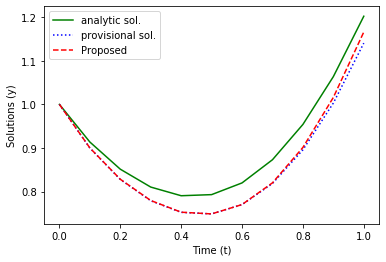

In [12]:
res =  psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space]

aa= [neural_network(W, xi)[0] for xi in x_space]
print(aa)
beingsaved = plt.figure()
plt.plot(x_space, y_space, 'g-',label='analytic sol.') 
plt.plot(x_space, psy_fd, 'b:',label='provisional sol.')
plt.plot(x_space, res, 'r--',label='Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Solutions (y)')
plt.legend()
plt.show()

In [13]:
print(np.linalg.norm(y_space - res))    # 빨간색 에러
print(np.linalg.norm(y_space - psy_fd)) # 파란색 에러

0.12920344103595321
0.1464926370136472


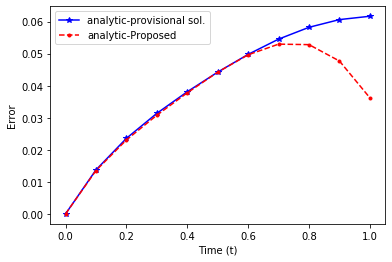

In [14]:
beingsaved1 = plt.figure()
plt.plot(x_space, abs(y_space-psy_fd), 'b*-',label='analytic-provisional sol.') 
plt.plot(x_space, abs(y_space-res), 'r.--',label='analytic-Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Error')
plt.legend()
plt.show()

In [15]:
print(abs(y_space-psy_fd))
print(psy_fd)
print(res)

[0.         0.01373522 0.02358341 0.03138227 0.03812134 0.04423903
 0.04977717 0.05453251 0.05822219 0.0606262  0.0616698 ]
[1.         0.9        0.82783933 0.77903784 0.75242261 0.74883599
 0.77017339 0.81858278 0.89585611 1.00307362 1.14050709]
[1.         0.90020116 0.82834427 0.7796187  0.75276329 0.74884232
 0.77030278 0.82014778 0.90126771 1.01600466 1.16597107]
